# 9. Anoamaly detection [0.8]

## 9.1 Problem motivcation

已知 $\{x_1,x_2...,x_m\} , $ $x_m ∈ R^{·n}$，其中 n 代表特征个数。

问 $x_{test}$ 是否为异常？

其中 $x^{(i)} ∈ R^{·n}$ 代表第 i 个用户的活动。

可以为已有数据进行建模，得到模型 $p(x)$, 然后使用 $p(x) < ε$ 来标记异常（出现概率过小）。

## 9.2 Gaussian distribution

$x ∈ R，mean =~ μ，variance =~ σ^2$

对于数据估计而言，$\{x_1,x_2...,x_m\} , x^{(i)} ∈ R$ 

$x^{(i)} -~ N(μ,σ^2)$, 其中 $μ = \frac{1}{m}\sum^{m}_{i=1}x^{(i)},~σ^2=\frac{1}{m}\sum^m_{i=1}(x^{(i)}-μ)^2$

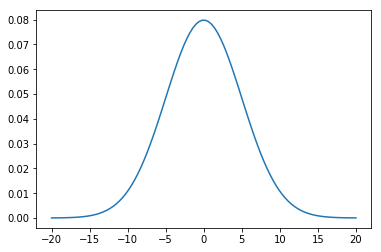

In [6]:
from scipy.stats import norm ;import numpy;import matplotlib.pyplot as plt
vx = numpy.linspace(-20,20,100) ; vy = norm.pdf(vx,0,5) ;plt.plot(vx,vy)

## 9.3 Algorithm

已知 $\{x_1,x_2...,x_m\} ,~ each ~ x ∈ R^{~n}$ 

则：
$x_1 -~ N(μ_1,σ^2_1)~,$
$x_2 -~ N(μ_2,σ^2_2)~,$
$x_3 -~ N(μ_3,σ^2_3)~$

那么，可有下列公式得到总的分布关系：

$$p(x) = p(x_1:u_1,σ^2_1)~p(x_2:u_2,σ^2_2)...~p(x_n:u_n,σ^2_n) = \prod^n_{j=1}p(x_j:μ_j,σ^2_j)$$

**计算过程**

1.选择可能检测出异常的特征维度 $x_i$

2.拟合参数 $μ_1...μ_n,σ^2_1,...σ^2_n$

$$μ = \frac{1}{m}\sum^{m}_{i=1}x^{(i)},~σ^2=\frac{1}{m}\sum^m_{i=1}(x^{(i)}-μ)^2$$

3.计算 $p(x)$

$$p(x) = \prod^n_{j=1}p(x_j:μ_j,σ^2_j) = \prod^n_{j=1}\frac{1}{\sqrt{2π}σ_j}exp(-\frac{(x_j-μ_j)^2}{2σ_j^2})$$

## 9.4 Developing and Evaluating

按照以下的划分方法，将数据划分成三部分：

$$Training Set：\{(x_1,y_1)...(x_{train}^{m_{train}},y_{train}^{m_{train}})\}$$

$$CV: \{(x_{cv}^1,y_{cv}^1)...(x_{cv}^{m_{cv}},y_{cv}^{m_{cv}})\}$$

$$Test： \{(x_{test}^1,y_{test}^1)...(x_{test}^{m_{test}},y_{test}^{m_{test}})\}$$

**假设有10000个正常零件，20个缺陷零件，则使用完全的正常零件训练测试集合，使用10个缺陷零件进行交叉验证和改进算法，使用10个缺陷零件来进行测试。其中正常零件的比例为3：1：1**

如果 p(x) < ε 则异常，反之则正常，异常 y = 1，正常 y = 0.

对于交叉验证集合( CV )，使用其选择合适的 ε 。

对于测试集合（TEST），使用 召回率/精度/F1分数来进行评估。




## 9.5 vs. Supervised learning

和监督学习不同，异常检测只有很少的异常集合，却有很大的正常集合。这种偏斜很难通过监督学习——Logistic回归/SVM进行学习和分类。并且异常特征可能是我们从未见过的，所以在这种情况下，我们能够利用的，就是正常特征的大量分布，因此就有了异常检测。

和垃圾邮件过滤不同，垃圾邮件虽然也是一个偏斜的例子，但是有足够的异常样本可以用来进行训练。总而言之，监督学习分类要求大量的正常、异常样本，最好还不能是偏斜的（但也可以对付）。而异常检测中没有足够的异常样本，也不可能有，所以不能使用监督学习分类方法。

## 9.6 Features Choosing



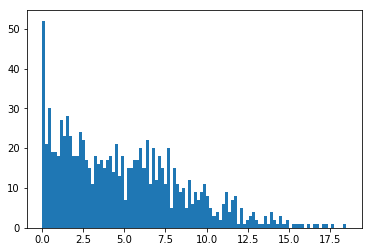

In [44]:
vx_g = np.linspace(0,10,1000);vy_g = numpy.random.gamma(vx_g)
_=plt.hist(vy_g,bins=100);

对于偏斜特征的数据，可以将这些数据进行变换并使用，比如，进行对数变换，当所有特征经过变换后都是正态的，就可以进行使用。

比如：对于计算机异常检测，其特征有：

- 内存使用
- 硬盘访问量
- CPU使用
- 网络状况

那么，一般而言，对于计算机系统过载，可能出现的是 高CPU负荷以及网络拥堵，但是不太可能出现高CPU负荷以及网络正常，因此标记新特征 X4 为 CPU/NETWORK TRAFFIC, 但这样的话，分布不是高斯的，所以可以尝试标记 X4 =  CPU^2/NETWORK TRAFFIC，这样就可以生成一组正态的，对错误敏感的特征用于某种类型的异常检测。

总而言之，在进行错误监测的时候，一定要手动构建对异常敏感的特征，并经过变换让其处于近似正态分布。

## 9.7 Multivariate Gaussian distribution

联合高斯分布指的是，不单独对每个特征进行建模，然后求其乘积，而是直接计算多元高斯分布，然后对其进行迭代和预测。

这可以解决以下问题：

![](datacenter.png)

分布在不同特征上呈现线性，而非一个圆，这样的话，当出现在图左那些有×标记的地方时，在各个维度依然会被标记为正常，但在总的维度显然不正常，这样就难以检测到。

$$p(x:μ,Σ)=\frac{1}{(2π)^{\frac{n}{2}}|Σ|^{\frac{1}{2}}}exp(-\frac{1}{2}(x-μ)^TΣ^{-1}(x-μ))$$

其中，$μ ∈ R^{~n}, ~Σ ∈ R^{~n×n} (协方差矩阵)$

$$μ = \frac{1}{m}\sum^m_{i=1}x^{(i)},~~Σ = \frac{1}{m}\sum^m_{i=1}(x^{(i)}-μ)(x^{(i)}-μ)^T$$

### Nromal Examples

![](mge1.png)

对于协方差矩阵的斜对角线而言，更改大小影响每个维度的方差，如上图所示。

![](mge2.png)

![](mge3.png)

如果元素不等，那么分布会变成椭圆。改变对角线第1个元素，特征1改变方差。改变对角线第2个元素，特征2改变方差。

![](mge4.png)

如果对称对角线同步缩小，那么在相同方向会被压缩

![](mge5.png)

如果对称对角线同步负向缩小，那么在相反方向会被压缩

![](mge6.png)

如果改变 μ，那么中心会向它处偏移。

## 9.8 How to choose model

相比较新模型，老模型可以看作是 ∑ 协方差矩阵的对角线有元素，而其余地方没有元素的新模型的特殊形式。

相比较新模型，老模型需要手动构建能够检测出异常的特征，并让其近似高斯分布，这样的工作就类似于将矩阵除了对角线的其余部分去除并且将数值合并到对角线部分。对于 n = 10000 这样的大样本，计算的成本更低，当数据量 m 不太多的时候也可以正常运行。

而新模型而言，其需要计算 n × n 的协方差矩阵，还要求逆，运算量很大。但是优点是可以自动捕获异常特征，当 m >> n , 一般取 m > 10n 的时候，也就是说，数据量非常大并且特征不太多的时候使用。

因为我们假设所有特征的分布都是正态分布，因此不需要进行特征的加权。

# 10. Recommender System [0.9]

推荐系统是为了解决电影×用户评分矩阵中数据缺失的问题。

推荐系统是一种特殊的线性回归。在推荐系统中，不考虑对特征进行维度的增减以及截距项的计算。因为我们已经假设特征含有几乎为零的信息，我们已知这些电影的信息，比如日期，类型，简介，然后根据标签——用户评级来进行推测，得到一个线性方程。这个线性方程的参数就是电影向量。我们可以根据这个模型来推测所有电影的可能评分。

然而推荐系统并不仅如此，当我们得到这些所有电影的评分（电影特征向量）后，我们可以用此作为固定值，以用户特征向量组作为自变量，以标签——用户评级来继续训练，得到一个线性方程，这个线性方程的参数就是用户向量。

循环往复的计算，就可以让这两个向量的参数最优。而仅仅需要的是一点点数据/标签，以及对向量大小（维度）的确定。

对于一般多元线性回归，一个新特征，乘以特征向量就是其预测值。而对于推荐系统，两个特征向量相乘可以得到一个矩阵，这个矩阵就是所有用户对于所有电影的评分，其中一部分是之前的数据，而其余部分都是通过线性回归猜测的。

## 10.1 Problem formulation

$n_m~ 电影个数,~~ n_u~ 用户个数$

$r(i,j)=1~如果用户j评价了电影i$

$y(i,j)=用户j对于电影i的评分（如果有的话）$

$θ^{(j)}=用户j的特征向量$

$x^{(i)}=电影i的特征向量$


$m^{(j)} = 用户j一共评价了的电影总数$

对于用户j的电影i，预测评分为：$(θ^{(j)})^T(x^{(i)})$

为了学习$θ^{(j)}$，那么需要优化以下公式：

$$min_{θ_j}\frac{1}{2}\sum_{i:r(i,j)=1}((θ^{(j)})^Tx^{(i)}-y^{(i,j)})^2+\frac{\lambda}{2}\sum^n_{k=1}(θ_k^{(j)})^2$$

为了学习$θ^{(1)}...θ^{(n_u)}$，那么需要优化以下公式：

$$min_{θ_1,..θ_{n_u}}\frac{1}{2}\sum_{j=1}^{n_u}\sum_{i:r(i,j)=1}((θ^{(j)})^Tx^{(i)}-y^{(i,j)})^2+\frac{\lambda}{2}\sum_{j=1}^{n_u}\sum^n_{k=1}(θ_k^{(j)})^2$$

Cost Function Gradient descent update:

$$\theta^{(j)}_k := \theta^{(j)}_k - \alpha\sum_{i:r(i,j)=1}((θ^{(j)})^Tx^{(i)}-y^{(i,j)})\theta^{(j)}_k~(for~ k = 0)$$

$$\theta^{(j)}_k := \theta^{(j)}_k - \alpha \left(\sum_{i:r(i,j)=1}((θ^{(j)})^Tx^{(i)}-y^{(i,j)})x^{(i)}_k + \lambda\theta^{(j)}_k \right)~(for~ k ≠ 0)$$

![](rs1.png)

如上图所示，每个电影有一个 $x^{(i)}$ 的向量，每一个用户有 $θ^{(j)}$ 的向量，每个 $θ^{(j)}∈R^3$

很显然的，我们在做的事情就是，将每个用户看作一次实验，对每个用户进行一次监督学习的线性回归。但是现实问题是，我们并非在用户向量或者电影向量上有足够数据，协同过滤算法考虑到了更为复杂的关系：迭代的对于电影向量和用户向量进行线性回归，然后用拟合过的参数充当定量在另一个维度重新拟合。

## 10.2 Collaborative filtering

![](rs2.png)

很多时候，我们没有足够的电影信息，这时候可以根据用户向量和评分推导电影向量：

给定用户向量 $θ^{(1)}...θ^{(n_u)}$，需要学习 $x^{(1)}...x^{(n_m)}$ 

$$min_{θ_1,..θ_{n_m}}\frac{1}{2}\sum_{i=1}^{n_m}\sum_{j:r(i,j)=1}((θ^{(j)})^Tx^{(i)}-y^{(i,j)})^2+\frac{\lambda}{2}\sum_{i=1}^{n_m}\sum^n_{k=1}(x_k^{(j)})^2$$

协同过滤指的是：

给定电影向量(x)和其评分（y），估计用户向量（θ，偏好）

给定用户向量θ，估计电影向量（x）

顺序：θ -> x -> θ -> x ...



**Collabortive filtering algorithm**

给定电影向量$x^{(1)}...x^{(n_m)}$，学习用户向量$θ^{(1)}...θ^{(n_u)}$：

$$min_{θ_1,..θ_{n_u}}\frac{1}{2}\sum_{j=1}^{n_u}\sum_{i:r(i,j)=1}((θ^{(j)})^Tx^{(i)}-y^{(i,j)})^2+\frac{\lambda}{2}\sum_{j=1}^{n_u}\sum^n_{k=1}(θ_k^{(j)})^2$$

给定用户向量 $θ^{(1)}...θ^{(n_u)}$，需要学习 $x^{(1)}...x^{(n_m)}$ ：

$$min_{θ_1,..θ_{n_m}}\frac{1}{2}\sum_{i=1}^{n_m}\sum_{j:r(i,j)=1}((θ^{(j)})^Tx^{(i)}-y^{(i,j)})^2+\frac{\lambda}{2}\sum_{i=1}^{n_m}\sum^n_{k=1}(x_k^{(i)})^2$$

总和起来，就是：

$$J(x^{(1)...x^{(n_m)}},\theta^{(1)}...\theta^{n_u}) = \frac{1}{2}\sum_{(i,j):r(i,j)=1}((θ^{(j)})^Tx^{(i)}-y^{(i,j)})^2+\frac{\lambda}{2}\sum_{i=1}^{n_m}\sum^n_{k=1}(x_k^{(i)})^2+\frac{\lambda}{2}\sum_{j=1}^{n_u}\sum^n_{k=1}(θ_k^{(j)})^2$$

所以，步骤是：

- 初始化所有的 x 和 θ 为随机小的值。
- 最小化 J 函数，使用梯度下降或者其他算法
其中，对于梯度下降来说，

$$\theta^{(j)}_k := \theta^{(j)}_k - \alpha \left(\sum_{i:r(i,j)=1}((θ^{(j)})^Tx^{(i)}-y^{(i,j)})x^{(i)}_k + \lambda\theta^{(j)}_k \right)$$

$$x^{(i)}_k := x^{(i)}_k - \alpha \left(\sum_{j:r(i,j)=1}((θ^{(j)})^Tx^{(i)}-y^{(i,j)})\theta^{(j)}_k + \lambda x^{(i)}_k \right)$$
- 对于用户向量 θ 和电影向量 x，预测为 $(\theta^{(j)})^T(x^{(i)})$

因为所有的变量都可以经过自己的学习，因此没有必要规定一个全部为1的截距项，如果程序需要，它可以自己学习一个出来。

## 10.3 Low rank matrix factorization

低秩矩阵分解指的是协同过滤系统的向量化表示。

其中 x 和 θ 分别为 电影向量和用户向量 ∈ 1×n；

X 为电影总的向量，$X ∈ R^{~n_m~ × ~d_m}$， 其中每行代表一部电影，每列代表电影的一个描述维度

Θ 为用户总的向量，$\Theta ∈ R^{~n_u~ × ~d_u}$，其中每行代表一个用户，每列代表用户的一个描述维度

Y 为评分向量，如下所示， $Y ∈ R^{~n_m~ × ~n_u}$，其中每行代表每一电影，每列代表每一用户。

![](xytheta.png)

LRMF可以找到最相近的电影/用户，这和K-NN很相似，只要计算不同电影/用户的欧几里得距离或者其它距离（比如cosine距离）即可，距离越小，关系越近。$Distance = ||x^{(i)}-x^{(j)}||$

## 10.4 Mean normalization

正则化在线性拟合中作用主要是避免过拟合的问题，在LRMF中，其主要作用是避免出现极端值的问题。思考一下，对于一个新用户，其对所有电影都没有评分，那么根据J函数，其最小化J的结果是，所有的θ值都为0（因为只剩下正则化项），这意味着我们无法向其推荐电影，因为0没有任何意义。

解决的办法是使用平均θ来代替这些全部为0的θ值。换句话说，使用每部电影的平均评分来正则化 Y 矩阵。Y := Y - μ。这里不需要除以δ的原因是，本来评分就是等比的，所以不需要重新缩放，而只需要避免极端值的问题就行。

# I. 附录

## i. `LRMF` 算法 的 `MATLAB` 实现
LRMF 方法 Cost Function 和 J 函数的实现：

```matlab
function [J, grad] = cofiCostFunc(params, Y, R, num_users, num_movies, ...
                                  num_features, lambda)
%COFICOSTFUNC Collaborative filtering cost function
%   [J, grad] = COFICOSTFUNC(params, Y, R, num_users, num_movies, ...
%   num_features, lambda) returns the cost and gradient for the
%   collaborative filtering problem.
%

% Unfold the U and W matrices from params
X = reshape(params(1:num_movies*num_features), num_movies, num_features);
Theta = reshape(params(num_movies*num_features+1:end), num_users, num_features);

J = 0;
X_grad = zeros(size(X));
Theta_grad = zeros(size(Theta));

A = (X*Theta' - Y);
B = A.^2;
reg_j = lambda / 2 * sum(sum(Theta.^2)) + lambda / 2 * sum(sum(X.^2));
J = 1/2 * sum(B(R==1)) + reg_j;

for i = 1: num_movies
    idx = find(R(i, :)==1); %索引那些对于此电影有评分的数据位置
    Theta_temp = Theta(idx, :);% 对于此电影而言，找到那些有评价的人的特征集合
    Y_temp = Y(i, idx);% 找到此部电影的有评价的人的分数，Y是以电影*人排列的矩阵
    reg_x = lambda .* X(i, :); % 对于此电影各向量正则化
    X_grad(i, :) = (X(i,:)*Theta_temp' - Y_temp) *  Theta_temp + reg_x;  % 5/1*3
end

%同上计算用户矩阵的迭代，此处忽略迭代步长
for j = 1 : num_users
    idx = find(R(: , j ) ==1);%选择某位用户对评价过的电影的索引
    X_temp = X(idx, :); % 根据此索引查找评价过的电影的集合
    Y_temp = Y(idx, j ); % 选择用户j对于所有他评分过电影的评分
    reg_theta = lambda .* Theta(j, :);
    Theta_grad(j, :) = (X_temp * Theta(j,:)' - Y_temp)' * X_temp + reg_theta; % 4/1*3
end

grad = [X_grad(:); Theta_grad(:)];
end
```



其中，X 为电影总的向量，$X ∈ R^{~n_m~ × ~d_m}$， 其中每行代表一部电影，每列代表电影的一个描述维度

Θ 为用户总的向量，$\Theta ∈ R^{~n_u~ × ~d_u}$，其中每行代表一个用户，每列代表用户的一个描述维度

Y 为评分向量， $Y ∈ R^{~n_m~ × ~n_u}$，其中每行代表每一电影，每列代表每一用户。此处的Y经过归一化。

R 为是否有评分向量，$R ∈ R^{~n_m~ × ~n_u}$，其中每行代表每一电影，每列代表每一用户。R的值有0和1，0代表无数据，1代表有数据。
## ii. 异常检测算法的 `MATLAB` 实现

**高斯函数的实现**

```matlab
function [mu sigma2] = estimateGaussian(X)
%ESTIMATEGAUSSIAN This function estimates the parameters of a 
%Gaussian distribution using the data in X
%   [mu sigma2] = estimateGaussian(X), 
%   The input X is the dataset with each n-dimensional data point in one row
%   The output is an n-dimensional vector mu, the mean of the data set
%   and the variances sigma^2, an n x 1 vector
%

% Useful variables
[m, n] = size(X);

mu = zeros(n, 1);
sigma2 = zeros(n, 1);

mu = sum(X,1)' .* (1/m); %mu in n*1
sigma2 = sum(((X - repmat(mu',m,1))).^2, 1) .* (1/m);

end
```

**最优估计(ε)的实现**

```matlab
function [bestEpsilon bestF1] = selectThreshold(yval, pval)
%SELECTTHRESHOLD Find the best threshold (epsilon) to use for selecting
%outliers
%   [bestEpsilon bestF1] = SELECTTHRESHOLD(yval, pval) finds the best
%   threshold to use for selecting outliers based on the results from a
%   validation set (pval) and the ground truth (yval).
%

bestEpsilon = 0;
bestF1 = 0;
F1 = 0;

stepsize = (max(pval) - min(pval)) / 1000;
for epsilon = min(pval):stepsize:max(pval)


    cvPredictions = (pval < epsilon);   
    tp = sum((cvPredictions == 1) & (yval == 1));
    fp = sum((cvPredictions == 1) & (yval == 0));
    fn = sum((cvPredictions == 0) & (yval == 1));
    prec = tp/(tp+fp);
    rec = tp/(tp+fn);
    F1 = (2*prec*rec)/(prec+rec);

    if F1 > bestF1
       bestF1 = F1;
       bestEpsilon = epsilon;
    end
end
end
```